<해커톤 주제> 04.23일 오후 5시
고객들의 미래 소비를 예측 분석프로젝트를 진행하려 합니다.

고객들의 월별 총 구매 금액을 확인했을 때 
연말에 소비가 많이 이루어지고 있는 것으로 확인이 되었습니다.

그리하여 12월을 대상으로 고객들에게 프로모션을 통해 성공적인 마케팅을 하기 위해 모델을 만들려고 합니다.

온라인 거래 log 데이터는 2009년 12월부터 2011년 11월까지의 온라인 상점의 거래 데이터가 주어집니다.
2011년 11월 까지 데이터를 이용하여 2011년 12월의 고객 구매액 300초과 여부를 예측해야 합니다.

고객들의 구입이 이루어질 때 1개의 데이터가 생성이 되며 데이터에는 

(고객 id / 고객 거주 국가), 상품 정보(상품 id / 상품 설명 / 상품 가격)와 거래 정보(주문 일자 / 상품 수량)

데이터 컬럼 설명
order_id : 주문 번호. 데이터에서 같은 주문번호는 동일 주문을 나타냄
product_id : 상품 번호
description : 상품 설명
quantity : 상품 주문 수량
order_date : 주문 일자
price : 상품 가격
customer_id : 고객 번호
country : 고객 거주 국가
total : 총 구매액(quantity X price)
    
평가 매트릭 :
from sklearn.metrics import roc_auc_score
score = roc_auc_score(labels,preds)

In [112]:
!pip install xgboost
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [113]:
import pandas as pd
import numpy as np
import sklearn as skl
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import xgboost as xgb
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings(action='ignore')
# from pycaret.classification import *

# data = pd.read_csv("./train.csv")
data = pd.read_csv("/content/drive/MyDrive/hackathon/train.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780502 entries, 0 to 780501
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   order_id     780502 non-null  object 
 1   product_id   780502 non-null  object 
 2   description  780502 non-null  object 
 3   quantity     780502 non-null  int64  
 4   order_date   780502 non-null  object 
 5   price        780502 non-null  float64
 6   customer_id  780502 non-null  int64  
 7   country      780502 non-null  object 
 8   total        780502 non-null  float64
dtypes: float64(2), int64(2), object(5)
memory usage: 53.6+ MB


In [114]:
#결측 확인
data.isnull().sum()

order_id       0
product_id     0
description    0
quantity       0
order_date     0
price          0
customer_id    0
country        0
total          0
dtype: int64

In [115]:
#기본 통계량
data.describe(include='all')

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total
count,780502,780502,780502,780502.000000,780502,780502.000000,780502.000000,780502,780502.000000
unique,43955,4645,5297,NaN,40615,NaN,NaN,41,NaN
top,576339,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,2011-11-14 15:27:00,NaN,NaN,United Kingdom,NaN
freq,542,5096,5096,NaN,543,NaN,NaN,700317,NaN
mean,NaN,NaN,NaN,12.623307,NaN,6.140931,15313.393466,NaN,33.715373
std,NaN,NaN,NaN,143.906302,NaN,119.042266,1695.765797,NaN,274.207403
min,NaN,NaN,NaN,-74215.000000,NaN,0.000000,12346.000000,NaN,-127352.940000
25%,NaN,NaN,NaN,2.000000,NaN,2.062500,13963.000000,NaN,7.260000
50%,NaN,NaN,NaN,5.000000,NaN,3.217500,15239.000000,NaN,19.470000
75%,NaN,NaN,NaN,12.000000,NaN,6.187500,16788.000000,NaN,32.175000


In [116]:
#고객별 구매 회수, 구매당 평균 금액, 구매당 평균 수량 확인하기
data2 = data.groupby('customer_id').describe() #시간이 걸린다.

In [117]:
data2.head(5)

quantity                           ...    total                    
               count       mean           std  ...      50%      75%        max
customer_id                                    ...                             
12346           47.0   1.127660  15474.897433  ...  12.3585  12.3585  127352.94
12347          211.0  13.151659     17.701647  ...  28.0500  38.6100     411.84
12348           51.0  53.215686     48.700848  ...  33.6600  68.9040     396.00
12349          180.0   8.994444      7.846643  ...  29.2050  33.6600     495.00
12350           17.0  11.588235      4.345383  ...  32.6700  41.5800      66.00

[5 rows x 24 columns]

In [118]:
'''사용자별 월별 구매 금액 건수 등으로 집계하고십다.'''
#고객 고유번호 배열
cids=data.customer_id.unique()
cids.sort()
print(type(cids))
print('고유한 cids length : ', len(cids))

#년월 컬럼 생성
data['yyyy-mm']=data['order_date'].str[0:7]

<class 'numpy.ndarray'>
고유한 cids length :  5914


In [119]:
'''환불 횟수가 영향 있을까?''' #고객별 환불 거래 횟수를 알아보자
refund_count = data[data.total <0].groupby(['customer_id']).size()
refund_count[:5] #피처를 추가하자 점수가 떨어졌다.

customer_id
12346    13
12349     5
12352    10
12359     6
12360     1
dtype: int64

In [120]:
'''고가 상품을 사는 고객을 구분해볼까?'''
# high_price = data.groupby(['customer_id']).max()
# high_price
'''price.mean 으로 평균 구매금액 순위가 이미 있다.'''

'descript에서 price.mean 으로 평균 구매금액 순위가 이미 있다.'

In [121]:
#select * from data where customer_id = min()
#아이디 제일 빠른 사람의 기록만 보기
minid= data.customer_id.min()
data[data.customer_id == minid]
data[(data.customer_id == minid) & (data.order_date.str.startswith('2009'))] #& 할때 반드시 각각을 괄호로 묶어야 함.

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,yyyy-mm
21447,491725,TEST001,This is a test product.,10,2009-12-14 08:34:00,7.425,12346,United Kingdom,74.250,2009-12
21702,491742,TEST001,This is a test product.,5,2009-12-14 11:00:00,7.425,12346,United Kingdom,37.125,2009-12
21705,491744,TEST001,This is a test product.,5,2009-12-14 11:02:00,7.425,12346,United Kingdom,37.125,2009-12
28492,492718,TEST001,This is a test product.,5,2009-12-18 10:47:00,7.425,12346,United Kingdom,37.125,2009-12
28504,492722,TEST002,This is a test product.,1,2009-12-18 10:55:00,1.650,12346,United Kingdom,1.650,2009-12


In [122]:
# timelabel=pd.date_range(data.order_date.min(), periods=25, freq='M').tolist()
# timelabel[0].
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

time :  0.3073086738586426


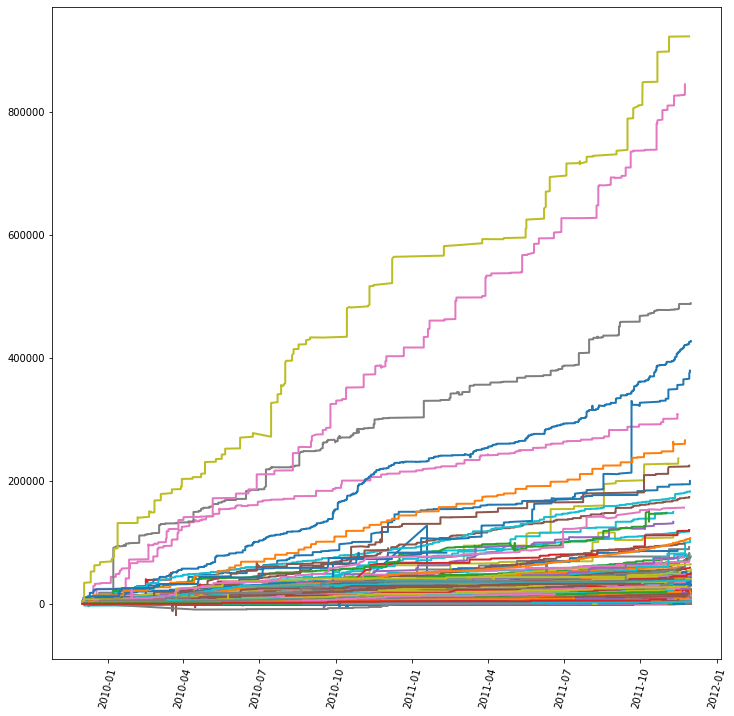

time :  37.070290327072144


In [123]:
'''내려갔다 다시 여기 올게요.'''
# 빨리 그리는 방법이 없나요?
# 로그차트를 써볼까요? 이건 못했고요
start = time.time()
cdata=data.copy()
#문자열을 타임으로 형변환 해야야 그래프 겹쳐짐
cdata['order_date']=pd.to_datetime(cdata['order_date']) 
#누적 구매액 그래프를 보자.
print('time : ', time.time()-start)
plt.rcParams["figure.figsize"] = (12,12)
plt.rcParams['lines.linewidth'] = 2
for i in cids[:]: #모든 사용자 누적 구매금액 차트....
    tsum = cdata[(cdata.customer_id == i)][['order_date','total']]
    tsum['total_cumsum']=tsum.total.cumsum() #속도 차이 별로 없음
    plt.plot(tsum.order_date, tsum.total_cumsum)
plt.xticks(rotation=75)
plt.show()
print('time : ', time.time()-start) #그리는 시간은 얼마?

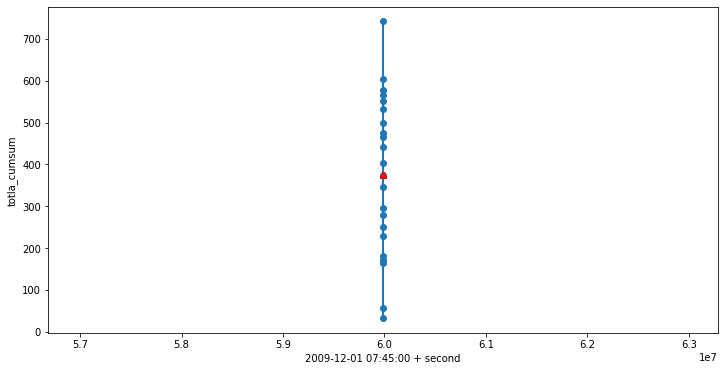

In [124]:
#사용자별 구매 패턴을 볼까?
xgr = xgb.XGBRegressor(learning_rate=0.15,
                           max_depth=5,
                           n_estimators=50,
                           objective='reg:squarederror')
#기준일
fday=pd.to_datetime(cdata.order_date.min())

for i in cids[100:101]: 
    tsum = cdata[(cdata.customer_id == i)][['order_date','total']]
    tsum['total_cumsum']=tsum.total.cumsum() #루프 안에서 돌려도 속도 차이 별로 없음
    #모델이 타임으로 안돌아서 숫자로 열심히 바꿔 보았다.
    X=(tsum.order_date - fday).dt.total_seconds().values.reshape(-1,1)
    y=tsum.total_cumsum.values.reshape(-1,1)
    #print(X.shape, y.shape)
    xgr.fit(X, y)
    pred1=xgr.predict(X)
    
# 차트를 그려보자
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(X,y, marker='o', label='real')
plt.plot(X,pred1, marker='^', label='predict', color='red')
plt.ylabel('totla_cumsum')
plt.xlabel(str(fday)+' + second')
plt.show()
#빨간선이 예측선 고객별로 이런 이상한 그래프가 나오기도

In [125]:
#시간 차이를 초로 환산하기 연습
a=pd.to_datetime('2009-11-20')
b=pd.to_datetime('2009-11-05')
c=pd.Series([a, b])
# print('a-b', type(a-b).total_seconds())
print('a-b', (a-b).total_seconds())
print('a-b', (a-b).delta)
d = c-b
d.values

a-b 1296000.0
a-b 1296000000000000


array([1296000000000000,                0], dtype='timedelta64[ns]')

In [126]:
#고객 아이디와 주문아이디로 집계해보자.
data[(data.customer_id==minid)].groupby('order_id').sum()

,quantity,price,customer_id,total
order_id,,,,
491725,10,7.4250,12346,74.2500
491742,5,7.4250,12346,37.1250
491744,5,7.4250,12346,37.1250
492718,5,7.4250,12346,37.1250
492722,1,1.6500,12346,1.6500
493410,5,7.4250,12346,37.1250
493412,5,7.4250,12346,37.1250
494450,5,7.4250,12346,37.1250
495295,5,7.4250,12346,37.1250


In [127]:
#판다스 내장 함수가 제일 빠르다.
#그룹 토탈 섬이 빠른지 해보자
# year_month에 해당하는 고객 ID의 구매액의 합 계산
#    grped = df.groupby(['customer_id','year_month'], as_index=False)[['total']].sum()
start = time.time()
gsum=data.groupby(['customer_id','yyyy-mm'])['total'].sum()

#다른방법 :원하는 시간 간격으로 추출 가능하지만 시간이 걸린다.
# cdata = cdata.set_index('order_date')
#rsum=cdata.groupby(['customer_id'])['total'].resample('M').sum() #다른방법 
#cdata['customer_id'].index

pivoted=pd.DataFrame(gsum).unstack()
pivoted['total'].fillna(0.0 , inplace=True)
# pivoted.columns.name=None
print('time : ', time.time()-start)
pivoted
#cdata
# type(cdata.order_date[0])

time :  0.11784648895263672


total                   ...                               
yyyy-mm       2009-12 2010-01  2010-02  ...  2011-09    2011-10    2011-11
customer_id                             ...                               
12346        187.2750 -22.275    0.000  ...    0.000     0.0000     0.0000
12347          0.0000   0.000    0.000  ...    0.000  2135.6280     0.0000
12348          0.0000   0.000    0.000  ...  511.500     0.0000     0.0000
12349        -39.8475   0.000    0.000  ...    0.000     0.0000  2899.9575
12350          0.0000   0.000    0.000  ...    0.000     0.0000     0.0000
...               ...     ...      ...  ...      ...        ...        ...
18283          0.0000   0.000  159.885  ...  222.585   186.4335  1052.2215
18284          0.0000   0.000    0.000  ...    0.000     0.0000     0.0000
18285          0.0000   0.000  704.550  ...    0.000     0.0000     0.0000
18286        763.8675   0.000    0.000  ...    0.000     0.0000     0.0000
18287         -8.4150   0.000    0.000  ...    0.000  1768.8000     0.0000

[5914 rows x 24 columns]

In [128]:
#pivoted.columns

In [129]:
#고객의 국적을 보자.
aaa = data[['customer_id','country']]
aaa=aaa.sort_values(by='customer_id').drop_duplicates()

#고객아이디에 국적이 2개인 리스트 확인해보기
ccc=aaa['customer_id'].value_counts()
lll = ccc[ccc.iloc[:]>1].index.tolist() 
print(aaa[aaa['customer_id'].isin(lll)])

#처음 국적 유지하려면 keep='first' 기본값 유지
aaa=aaa.sort_values(by='customer_id').drop_duplicates('customer_id',keep='last') #나중 국적 선택
print('\n국적 하나만 선택\n', aaa[aaa.customer_id.isin(lll[:5])])
print(len(aaa), type(aaa))
aaa.head(5)

#그룹하면 중복이 있으면 단일, 중복 모두 배열로 들어가나 보다.
# ddd=data.groupby('customer_id')['country'].unique()
# print('len ddd = ', len(ddd))
#ddd
#배열에서 빼내기 어렵다 위의 코드를 쓰자.

        customer_id         country
415568        12370          Cyprus
419581        12370         Austria
519785        12394         Belgium
676543        12394         Denmark
425445        12413          France
338585        12413           Spain
603182        12417         Belgium
514343        12417           Spain
199440        12422     Switzerland
434366        12422       Australia
537184        12423         Belgium
250464        12423         Denmark
297214        12429         Denmark
512008        12429         Austria
38787         12431         Belgium
80687         12431       Australia
599485        12449         Belgium
326459        12449         Denmark
28853         12455          Cyprus
575219        12455           Spain
642347        12457     Switzerland
670606        12457          Cyprus
287679        12652         Germany
430400        12652          France
232670        12745  United Kingdom
48958         12745            EIRE

국적 하나만 선택
         customer

,customer_id,country
78392,12346,United Kingdom
440233,12347,Iceland
419393,12348,Finland
758299,12349,Italy
446282,12350,Norway


In [130]:
newdata = np.hstack((aaa,pivoted)) #옆으로 붙임
newdata.shape

(5914, 26)

In [131]:
newdata

array([[12346, 'United Kingdom', 187.275, ..., 0.0, 0.0, 0.0],
       [12347, 'Iceland', 0.0, ..., 0.0, 2135.6279999999997, 0.0],
       [12348, 'Finland', 0.0, ..., 511.5, 0.0, 0.0],
       ...,
       [18285, 'United Kingdom', 0.0, ..., 0.0, 0.0, 0.0],
       [18286, 'United Kingdom', 763.8674999999998, ..., 0.0, 0.0, 0.0],
       [18287, 'United Kingdom', -8.415, ..., 0.0, 1768.7999999999995,
        0.0]], dtype=object)

In [132]:
#달별 집계하고 사용할 컬럼 배열
mm=data['yyyy-mm'].unique()
np.sort(mm)
mm

array(['2009-12', '2010-01', '2010-02', '2010-03', '2010-04', '2010-05',
       '2010-06', '2010-07', '2010-08', '2010-09', '2010-10', '2010-11',
       '2010-12', '2011-01', '2011-02', '2011-03', '2011-04', '2011-05',
       '2011-06', '2011-07', '2011-08', '2011-09', '2011-10', '2011-11'],
      dtype=object)

In [133]:
newdf = pd.DataFrame(newdata, columns=['customer_id','country']+list(mm))
#list(mm)
newdf.head(5)

,customer_id,country,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11
0,12346,United Kingdom,187.275,-22.275,0,44.6325,0,0,-285.929,0,0,0,-9.075,0,0,0,0,0,0,0,0,0,0,0,0,0
1,12347,Iceland,0,0,0,0,0,0,0,0,0,0,1009.02,0,1174.45,784.393,0,0,1049.81,0,631.158,0,965.101,0,2135.63,0
2,12348,Finland,0,0,0,0,0,0,0,0,0,366.564,0,0,1473.12,375.276,0,0,605.55,0,0,0,0,511.5,0,0
3,12349,Italy,-39.8475,0,0,0,1763.06,330,0,0,0,0,2314.32,0,0,0,0,0,0,0,0,0,0,0,0,2899.96
4,12350,Norway,0,0,0,0,0,0,0,0,0,0,0,0,0,0,551.76,0,0,0,0,0,0,0,0,0


In [134]:
#국적을 팩토라이징
# country_encoded, country_class = pd.factorize(newdf['country'])
country_encoded, country_class = pd.factorize(aaa['country'])
newdf['country']=country_encoded
print(np.unique(country_encoded),'\n', country_class, '\nlenth = ', len(country_class))
#원래대로 되돌리기
print(country_class[country_encoded][:5])

#라벨 인코딩 
nation_le=skl.preprocessing.LabelEncoder()
nation_encoded= nation_le.fit_transform(aaa['country'].values)
print(np.unique(nation_encoded))
#원래대로 되돌리기
print(nation_le.inverse_transform(nation_encoded)[:5])

#원핫 인코딩 : 나라이름 41개라 큰 배열 비효율 적 , OneHotEncoder도 약간 복잡
dm = pd.get_dummies(aaa['country'])
print(dm)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40] 
 Index(['United Kingdom', 'Iceland', 'Finland', 'Italy', 'Norway',
       'Unspecified', 'Bahrain', 'Spain', 'Portugal', 'Switzerland', 'Austria',
       'Cyprus', 'Belgium', 'Denmark', 'Netherlands', 'Australia', 'RSA',
       'France', 'Germany', 'USA', 'Thailand', 'Sweden', 'Greece', 'Israel',
       'Saudi Arabia', 'Poland', 'United Arab Emirates', 'Singapore', 'EIRE',
       'Brazil', 'Japan', 'Lebanon', 'Korea', 'Czech Republic',
       'Channel Islands', 'European Community', 'Lithuania', 'Canada', 'Malta',
       'Nigeria', 'West Indies'],
      dtype='object') 
lenth =  41
Index(['United Kingdom', 'Iceland', 'Finland', 'Italy', 'Norway'], dtype='object')
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
['United Kingdom' 'Iceland' 'Finland' 'Italy' 'Norway']
        Australia  

In [135]:
#활불 회수 데이터 프레임
rfc = pd.DataFrame({'customer_id': refund_count.index,
                    'refund_count': refund_count.values})
rfc

,customer_id,refund_count
0,12346,13
1,12349,5
2,12352,10
3,12359,6
4,12360,1
...,...,...
2545,18280,2
2546,18282,1
2547,18284,1
2548,18286,3


In [136]:
#조인 하기 위해 인덱스를 컬럼으로.
data2['customer_id']=data2.index
#조인 월별 토탈 과 describe한 DataFrame을 customer_id로 조인
mdata=newdf.join(data2, on='customer_id')

#환불 회수도 머지해보자 : auc가 떨어졌다.
# mdata=mdata.merge(rfc, on='customer_id', how='left') #환불 없는 고객도 있으니 left join
# mdata.fillna(0,inplace=True) #머지 후 환불 없는 고객은 NaN이니까 0으로 채우자.
#mdata.shape
#mdata.info()
mdata.head(5)

,customer_id,country,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,"(quantity, count)","(quantity, mean)","(quantity, std)","(quantity, min)","(quantity, 25%)","(quantity, 50%)","(quantity, 75%)","(quantity, max)","(price, count)","(price, mean)","(price, std)","(price, min)","(price, 25%)","(price, 50%)","(price, 75%)","(price, max)","(total, count)","(total, mean)","(total, std)","(total, min)","(total, 25%)","(total, 50%)","(total, 75%)","(total, max)","(customer_id, )"
0,12346,0,187.275,-22.275,0,44.6325,0,0,-285.929,0,0,0,-9.075,0,0,0,0,0,0,0,0,0,0,0,0,0,47.0,1.127660,15474.897433,-74215.0,-1.0,1.0,1.0,74215.0,47.0,19.922872,40.530554,1.6500,7.42500,12.3585,12.35850,234.8115,47.0,-1.816404,26554.972603,-127352.9400,-1.77375,12.3585,12.3585,127352.94,12346
1,12347,1,0,0,0,0,0,0,0,0,0,0,1009.02,0,1174.45,784.393,0,0,1049.81,0,631.158,0,965.101,0,2135.63,0,211.0,13.151659,17.701647,2.0,6.0,12.0,12.0,240.0,211.0,4.230803,3.737299,0.4125,1.40250,3.2175,6.18750,21.0375,211.0,36.727827,36.057268,8.3160,21.78000,28.0500,38.6100,411.84,12347
2,12348,2,0,0,0,0,0,0,0,0,0,366.564,0,0,1473.12,375.276,0,0,605.55,0,0,0,0,511.5,0,0,51.0,53.215686,48.700848,1.0,22.0,24.0,88.0,144.0,51.0,6.247353,17.617275,0.4785,0.58575,0.9075,2.06250,66.0000,51.0,65.333529,72.939156,1.6500,21.78000,33.6600,68.9040,396.00,12348
3,12349,3,-39.8475,0,0,0,1763.06,330,0,0,0,0,2314.32,0,0,0,0,0,0,0,0,0,0,0,0,2899.96,180.0,8.994444,7.846643,-1.0,3.0,6.0,12.0,48.0,180.0,13.792075,53.400142,0.6930,2.45850,4.2075,10.35375,495.0000,180.0,40.374950,55.548906,-24.6675,24.50250,29.2050,33.6600,495.00,12349
4,12350,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,551.76,0,0,0,0,0,0,0,0,0,17.0,11.588235,4.345383,1.0,12.0,12.0,12.0,24.0,17.0,6.337941,15.402339,1.4025,2.06250,2.7225,3.46500,66.0000,17.0,32.456471,12.004638,14.0250,24.75000,32.6700,41.5800,66.00,12350


In [137]:
#학습데이터 준비.
#2010년12월이 라벨 , 2009-12월로 바꿔보자
y=mdata.loc[:, '2010-12'] 
# y=mdata.loc[:, '2009-12']
#300이상이나 아니냐에 따라 300과 0으로 바꿔서 이진 분류 타겟으로 만들어 줌
y=np.where(y<300,0, np.where(y>=300,300, y))
y.astype(int)

#print(X.columns)
X=mdata.drop(['customer_id',('customer_id','' ),'2010-12'],axis=1)
# X=mdata.drop(['customer_id',('customer_id','' ),'2009-12'],axis=1)
#print(X.columns)

X_train, X_test, y_train, y_test = train_test_split(X.astype(float),y.astype(int),random_state=42,stratify=y)

X.head(5)
#y

,country,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,"(quantity, count)","(quantity, mean)","(quantity, std)","(quantity, min)","(quantity, 25%)","(quantity, 50%)","(quantity, 75%)","(quantity, max)","(price, count)","(price, mean)","(price, std)","(price, min)","(price, 25%)","(price, 50%)","(price, 75%)","(price, max)","(total, count)","(total, mean)","(total, std)","(total, min)","(total, 25%)","(total, 50%)","(total, 75%)","(total, max)"
0,0,187.275,-22.275,0,44.6325,0,0,-285.929,0,0,0,-9.075,0,0,0,0,0,0,0,0,0,0,0,0,47.0,1.127660,15474.897433,-74215.0,-1.0,1.0,1.0,74215.0,47.0,19.922872,40.530554,1.6500,7.42500,12.3585,12.35850,234.8115,47.0,-1.816404,26554.972603,-127352.9400,-1.77375,12.3585,12.3585,127352.94
1,1,0,0,0,0,0,0,0,0,0,0,1009.02,0,784.393,0,0,1049.81,0,631.158,0,965.101,0,2135.63,0,211.0,13.151659,17.701647,2.0,6.0,12.0,12.0,240.0,211.0,4.230803,3.737299,0.4125,1.40250,3.2175,6.18750,21.0375,211.0,36.727827,36.057268,8.3160,21.78000,28.0500,38.6100,411.84
2,2,0,0,0,0,0,0,0,0,0,366.564,0,0,375.276,0,0,605.55,0,0,0,0,511.5,0,0,51.0,53.215686,48.700848,1.0,22.0,24.0,88.0,144.0,51.0,6.247353,17.617275,0.4785,0.58575,0.9075,2.06250,66.0000,51.0,65.333529,72.939156,1.6500,21.78000,33.6600,68.9040,396.00
3,3,-39.8475,0,0,0,1763.06,330,0,0,0,0,2314.32,0,0,0,0,0,0,0,0,0,0,0,2899.96,180.0,8.994444,7.846643,-1.0,3.0,6.0,12.0,48.0,180.0,13.792075,53.400142,0.6930,2.45850,4.2075,10.35375,495.0000,180.0,40.374950,55.548906,-24.6675,24.50250,29.2050,33.6600,495.00
4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,551.76,0,0,0,0,0,0,0,0,0,17.0,11.588235,4.345383,1.0,12.0,12.0,12.0,24.0,17.0,6.337941,15.402339,1.4025,2.06250,2.7225,3.46500,66.0000,17.0,32.456471,12.004638,14.0250,24.75000,32.6700,41.5800,66.00


In [138]:
xgmodel = xgb.XGBClassifier(maxrandom_state=42,
    learning_rate =0.015,n_estimators=50, max_depth=5,min_child_weight=8,
    gamma=0,reg_alpha=1e-05,subsample=0.67, colsample_bytree=0.75,
    objective= 'binary:logistic', nthread=-1,
    scale_pos_weight=8,) #드라마틱한 효과
xgmodel.fit(X_train,y_train)
pred2=xgmodel.predict(X_test)

print('score : ', classification_report(y_test,pred2))
score = roc_auc_score(y_test,pred2)
print('roc_auc_score : ',score)

# roc_auc_score :  0.6375786542297426 2010-1~11월 주고 10-12월을 예측
# roc_auc_score :  0.6581997937886044 2010-12월 빼고 전부 주면 => 11년치 구매 기록도 12월 찾는데 도움
# roc_auc_score :  0.6598716478603158 describe 주면
# roc_auc_score :  0.6674110735554483 stratify=target으로 분리하면 높아짐. /국적이 별로 영향이 없음.
# roc_auc_score :  0.7791056387145232 xg부스트 파라미터 조정 시작 
# roc_auc_score :  0.7843231933043618 xg부스트 파라미터 조정 결과 

# roc_auc_score :  0.7794879017114652 환불 피처 추가시 점수 하락
# score :        precision    recall  f1-score   support
#            0       0.96      0.83      0.89      1308
#          300       0.36      0.73      0.48       171

# roc_auc_score :  0.7463076616021754 2009-12월을 예측 한 결과.
# roc_auc_score :  0.7455342663972258
# 모델을09-12, 10-12 모델 두개를 모아서 11-12를 예측 해야 할 것 같음
# 고객아이디별 리그레션 결과도 참조해 보자.

score :                precision    recall  f1-score   support

           0       0.96      0.83      0.89      1308
         300       0.36      0.74      0.49       171

    accuracy                           0.82      1479
   macro avg       0.66      0.78      0.69      1479
weighted avg       0.89      0.82      0.84      1479

roc_auc_score :  0.7843231933043618


In [145]:
'''
환불 횟수를 피처로 만들어 추가했을 때 오히려 점수가 하락했다.
이유는 정확히 알 수 없다.
목표는 2011년 12월을 예측하는 모델을 만드는 것인데
2010년 12월을 타겟으로 했을 때
2009년 12월을 타겟으로 했을 때 점수가 차이가 나며
피처 중요도도 달라진다.
즉 근접한 달의 영향을 더 받는다.

그러므로 모델 두개와 추가로 
고객별 회귀 모델을 활용이 가능한지 모색해 봐야 하겠다.
'''
''

''

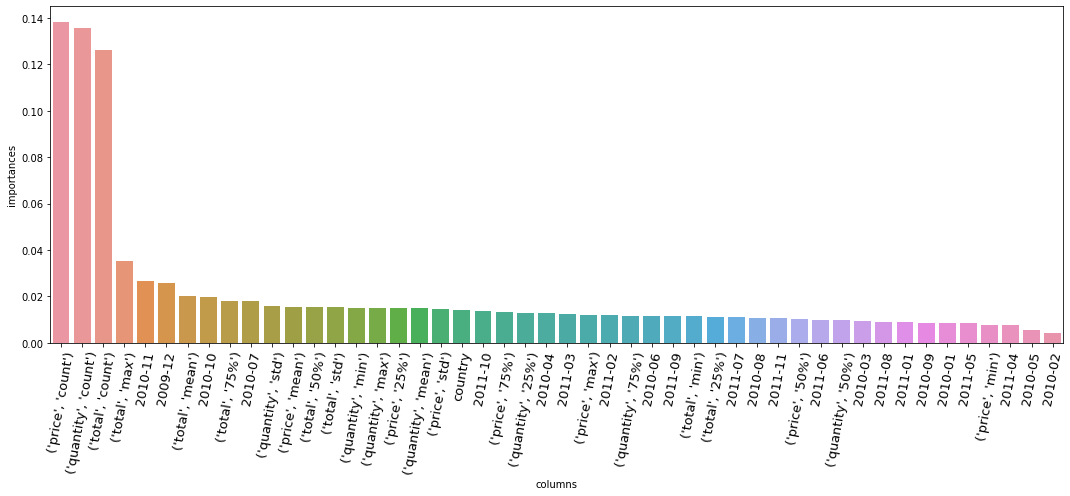

In [140]:
#피쳐 중요도
fi=xgmodel.feature_importances_
df_fi= pd.DataFrame({'columns':X.columns, 'importances':fi})
df_fi= df_fi.sort_values(by=['importances'],ascending=False) #내림차순 정렬
#피쳐 이름
fnames = df_fi['columns']
fnames = fnames.map(lambda x : str(x)) #튜플을 문자열로.
fig=plt.figure(figsize=(15,7))
ax =sns.barplot(fnames, df_fi['importances'])
ax.set_xticklabels(fnames, rotation=80, fontsize=13) #피쳐 이름 80도 돌림
plt.tight_layout()
plt.show()

In [141]:
'''
피쳐 중요도를 보니
많이 산 사람이 또 살 가능성 높고
앞뒤로 근접한 달과 연관이 있으며
매년 12월에 샀으면 살 가능성 높음

뭘 더 해볼까?

*년간 구매액
*년간 구매액 중 남은 구매력
*구매하는 물건의 종류에 따라서 성향이 다른가???

각 월을 타겟으로 나머지를 피처로 사용해서 
뻥튀기 해볼 수 있나???

* 2009년 12월을 타겟으로 써보자.
* 2011년 12월을 해보자 : 피쳐 중요도가 달라진다 근접한 월의 중요도가 올라간다.
* 환불 횟수를 피처로 만들어 봤지만 점수가 하락했다.
'''
''

''

<class 'str'>  :  15CM CHRISTMAS GLASS BALL 20 LIGHTSPINK CHERRY LIGHTS WHITE CHERRY LIGHTSRECORD FRAME 7" SINGLE SIZE STRAWBERRY CERAMIC TRINKET BOXPINK DOUGHNUT TRINKET POT SAVE THE PLANET MUGFANCY FONT HOME SWEET HO
<class 'str'>  :   CHRISTMAS GLASS BALL 20 LIGHTS CHERRY LIGHTS  CHERRY LIGHTSRECORD FRAME 7" SINGLE SIZE STRAWBERRY CERAMIC TRINKET BOX DOUGHNUT TRINKET POT SAVE THE PLANET MUGFANCY FONT HOME SWEET HOME DOORMATCAT BOW


<function matplotlib.pyplot.show>

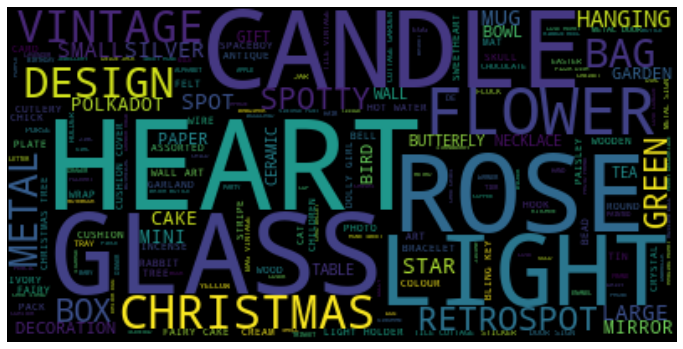

In [142]:
#워드 클라우드를 그려보자
from wordcloud import WordCloud

words = data.description.unique().sum() #sum()하면 스트링으로
print(type(words), ' : ', words[:200])

#명사가 아닌 것을 제거해 보자
filters = ['PINK','SET', 'RED','BLUE','WHITE', 'BLACK', '15CM']
for w in filters:
    words=np.char.replace(words,w,'') #
words=str(words)
print(type(words), ' : ', words[:200])

wcloud = WordCloud().generate(words)
# wcloud.words_

plt.figure(figsize=(12,12))
plt.imshow(wcloud, interpolation='bilinear')
plt.axis('off')
plt.show

https://www.google.com/search?q=HEART+MEASURING+SPOONS


In [143]:
#워드클라우드에서 눈에 띄는 상품을 다시 확인해 보자.
data[data.description.str.contains('ROSE|FLOWER')]

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,yyyy-mm
55,489438,21252,SET OF MEADOW FLOWER STICKERS,30,2009-12-01 09:24:00,2.7885,18102,United Kingdom,83.6550,2009-12
77,489439,16161P,WRAP ENGLISH ROSE,25,2009-12-01 09:28:00,0.6930,12682,France,17.3250,2009-12
96,489442,21955,UNION JACK GUNS & ROSES DOORMAT,2,2009-12-01 09:46:00,11.1375,13635,United Kingdom,22.2750,2009-12
111,489442,22025,RING OF ROSES BIRTHDAY CARD,12,2009-12-01 09:46:00,0.6930,13635,United Kingdom,8.3160,2009-12
113,489442,21428,SET3 BOOK BOX GREEN GINGHAM FLOWER,4,2009-12-01 09:46:00,7.0125,13635,United Kingdom,28.0500,2009-12
...,...,...,...,...,...,...,...,...,...,...
780413,579885,47578A,ENGLISH ROSE SMALL SCENTED FLOWER,1,2011-11-30 17:37:00,1.4025,15444,United Kingdom,1.4025,2011-11
780422,579885,84536A,ENGLISH ROSE NOTEBOOK A7 SIZE,6,2011-11-30 17:37:00,0.6930,15444,United Kingdom,4.1580,2011-11
780443,579885,47578A,ENGLISH ROSE SMALL SCENTED FLOWER,5,2011-11-30 17:37:00,1.4025,15444,United Kingdom,7.0125,2011-11
780482,579885,85034C,3 ROSE MORRIS BOXED CANDLES,4,2011-11-30 17:37:00,2.0625,15444,United Kingdom,8.2500,2011-11


In [144]:
#트리 시각화 해보기
# !pip install dtreeviz

from xgboost import plot_tree

# #피쳐 이름
# fnames = df_fi['columns']
# fnames = fnames.map(lambda x : str(x)) #튜플을 문자열로.
# print(fnames)
# plot_tree(xgmodel ,feature_names=fnames)
# plt.show()

# from dtreeviz.trees import *
# from dtreeviz.models.xgb_decision_tree import XGBDTree
# from IPython.display import Image, display_svg, SVG

# #피쳐 이름
# fnames = df_fi['columns']
# fnames = fnames.map(lambda x : str(x)) #튜플을 문자열로.


# xgb_s=XGBDTree(xgmodel, 1, 
#               X_train,
#               y_train,
#               target_name='2010-12',
#               feature_names=df_fi.columns,
#                )  

# dtreeviz(xgb_s)